# 2021-12-19 Update Note - (previous story of version 3)

- There is a significant loss of information (w.r.t. resolution) when saving image using `plt.imsave` and loading `PIL.open`.
- Thus, I will not save it but transform it directly. (Though I can find a way to not loss the information but it takes more memory (of data) and time.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


- I will use xresnet and their datablock, optimizer from fastai.

In [2]:
!git clone https://github.com/fastai/course-v3/ /content/course-v3

Cloning into '/content/course-v3'...
remote: Enumerating objects: 5893, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5893 (delta 0), reused 2 (delta 0), pack-reused 5890
Receiving objects: 100% (5893/5893), 263.03 MiB | 28.32 MiB/s, done.
Resolving deltas: 100% (3249/3249), done.


In [3]:
# restart-run
%cd /content/course-v3/nbs/dl2

/content/course-v3/nbs/dl2


- NOTE: if you do not have installed [nvidia/apex](https://github.com/nvidia/apex),  change `from exp.nb_10c import *` to `from exp.nb_10b import *` in `exp.nb_11`

In [4]:
from exp.nb_12a import *

- Local data (which is divided into separate dataset) is saved to `Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/v1/ser'`


In [59]:
root_path = Path('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/ser/v1'); root_path.ls()

[PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/ser/v1/train'),
 PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/ser/v1/dev')]

features-entry contains a list of a list with 26 items.
- length of inner list: 26 (float numbers - represent one preprocessed speech frame (logMel))

- length of outer list: number of frames per data-point, e.g. 10 or 15, ...

In [61]:
train_path = root_path/'train'

In [73]:
audios = get_files(train_path)

In [74]:
# restart-run
class AudioList(ItemList):
    @classmethod
    def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn):
        return torch.load(fn)

In [78]:
al=AudioList.from_files(train_path); al

AudioList (7800 items)
[PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/ser/v1/train/7760_1_1.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/ser/v1/train/7761_0_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/ser/v1/train/7762_0_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/ser/v1/train/7763_1_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/ser/v1/train/7764_1_1.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/ser/v1/train/7765_1_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/ser/v1/train/7766_1_1.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/ser/v1/train/7767_1_0.pt'), PosixPath('/gdrive/Shareddrives/Dion-Account/2122WS/8-dl4slp/coding-project/data/ser/v1/train/7768_1_0.p

In [26]:
al[0].shape, al[0].type()

(torch.Size([614, 26]), 'torch.FloatTensor')

## Inspect how the image changes thorugh I/O and byte/float conversion

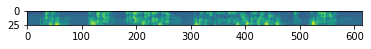

In [27]:
img = torch.load(al.items[0])
plt.imshow(img.t())

In [17]:
%cd /content/

/content


In [19]:
!ls

course-v3  sample_data	test1.png


In [18]:
plt.imsave('/content/test1.png', img.t())

In [21]:
reload_img = PIL.Image.open('test1.png'); reload_img

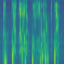

In [22]:
resize_img = reload_img.resize((64, 64)); resize_img

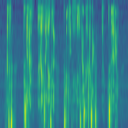

In [30]:
reload_img.resize((128, 128))

In [31]:
rgb_img = resize_img.convert("RGB")

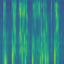

In [42]:
rgb_img

In [32]:
import inspect
def show_src(module): print(inspect.getsource(module))

In [34]:
show_src(to_float_tensor)

def to_float_tensor(item): return item.float().div_(255.)



In [33]:
show_src(to_byte_tensor)

def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)



In [36]:
res = torch.ByteTensor(torch.ByteStorage.from_buffer(rgb_img.tobytes())); res

tensor([ 53,  94, 140,  ...,  51,  96, 141], dtype=torch.uint8)

In [48]:
h, w = rgb_img.size
byte_img = res.view(h,w,-1).permute(2, 0, 1)

In [51]:
float_img = byte_img.float().div_(255.); float_img.shape

torch.Size([3, 64, 64])

In [56]:
#first channel
float_img[0].shape, float_img[0][0], float_img[0][0].type()

(torch.Size([64, 64]),
 tensor([0.2078, 0.2157, 0.2157, 0.1608, 0.1373, 0.1647, 0.2157, 0.2118, 0.2118,
         0.2157, 0.2235, 0.1804, 0.1373, 0.1490, 0.1294, 0.1216, 0.1647, 0.2235,
         0.2000, 0.1255, 0.1373, 0.1451, 0.1569, 0.1412, 0.1373, 0.1569, 0.1333,
         0.2000, 0.2235, 0.2157, 0.1961, 0.2039, 0.1843, 0.2000, 0.1451, 0.1765,
         0.1373, 0.1255, 0.1451, 0.1294, 0.1608, 0.1765, 0.1922, 0.1451, 0.1529,
         0.1608, 0.1804, 0.2157, 0.2078, 0.2275, 0.2000, 0.1451, 0.2000, 0.2000,
         0.1686, 0.1882, 0.1490, 0.1765, 0.1922, 0.2039, 0.1961, 0.2078, 0.2078,
         0.2157]),
 'torch.FloatTensor')

In [55]:
float_img[1][0]

tensor([0.3686, 0.3412, 0.3490, 0.4627, 0.5373, 0.4824, 0.3373, 0.3490, 0.3569,
        0.3529, 0.3294, 0.4314, 0.5216, 0.4863, 0.5451, 0.5765, 0.4588, 0.3059,
        0.3765, 0.5490, 0.5059, 0.5020, 0.4902, 0.5176, 0.5333, 0.4863, 0.5373,
        0.3843, 0.3333, 0.3412, 0.3804, 0.3804, 0.4157, 0.3725, 0.5098, 0.4235,
        0.5333, 0.5647, 0.4863, 0.5333, 0.4706, 0.4275, 0.3922, 0.5059, 0.4863,
        0.4706, 0.4275, 0.3451, 0.3647, 0.3216, 0.3922, 0.5059, 0.3804, 0.3725,
        0.4510, 0.3843, 0.4588, 0.4392, 0.3922, 0.3686, 0.3843, 0.3608, 0.3686,
        0.3529])

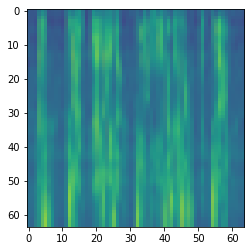

In [57]:
plt.imshow(float_img.permute(1,2,0))

## Train more epochs and finish the experiment (#closed)

1. AudioFileItemList
2. convert
  1. plt.save
  2. PIL.open, PIL.resize, to byte, to tensor

In [82]:
!mkdir data/

In [86]:
v2_path = Path('/content/data/v2')

In [89]:
train_v2 = v2_path/'train'; train_v2.mkdir(exist_ok=True, parents=True)

In [94]:
dev_v2 = v2_path/'dev'; dev_v2.mkdir(exist_ok=True, parents=True)

In [ ]:
for fpath in al.items:
    img_tensor = torch.load(fpath)
    trg_fname = fpath.stem + '.png'; print(trg_fname)
    plt.imsave(train_v2/trg_fname, img_tensor)

In [129]:
class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'

    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)

    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)

    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)


class ItemList(ListContainer):
    def __init__(self, items, path='.', tfms=None):
        super().__init__(items)
        self.path,self.tfms = Path(path),tfms

    def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'

    def new(self, items, cls=None):
        if cls is None: cls=self.__class__
        return cls(items, self.path, tfms=self.tfms)

    def  get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)

    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res,list): return [self._get(o) for o in res]
        return self._get(res)



In [128]:
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)

    def get(self, fn): return PIL.Image.open(fn)

class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)

    def get(self, fn): return PIL.Image.open(fn)



In [98]:
# restart-run
def re_labeler(fn, pat, subcl='act'):
    assert subcl in ['act', 'val', 'all']
    if subcl=='all': return ''.join(re.findall(pat, str(fn)))
    else:
        return re.findall(pat, str(fn))[0] if pat == 'act' else re.findall(pat, str(fn))[1]

In [99]:
# restart-run
label_pat = r'_(\d+)'
emotion_labeler = partial(re_labeler, pat=label_pat, subcl='all')
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())

In [100]:
uniqueify(ll.y.items)

[0, 1, 2, 3]

In [102]:
class ToCuda():
    _order=20
    def __call__(self, ad):
        return ad.cuda()

In [146]:
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    w,h = item.size
    return res.view(h,w,-1).permute(2,0,1)[0].unsqueeze(0) # return 1, H(LogMel), W(frames)

In [147]:
class ResizeFixed(Transform):
    _order=0
    def __init__(self,size):
        if isinstance(size,int): size=(size,size)
        self.size = size

    def __call__(self, item):
        print(type(item))
        return item.resize(self.size)
        # return item.resize(self.size, PIL.Image.BILINEAR)

In [148]:
il = ImageList.from_files(train_v2); il

ImageList (7800 items)
[PosixPath('/content/data/v2/train/6819_1_1.png'), PosixPath('/content/data/v2/train/5904_1_1.png'), PosixPath('/content/data/v2/train/5150_1_1.png'), PosixPath('/content/data/v2/train/103_1_0.png'), PosixPath('/content/data/v2/train/261_0_0.png'), PosixPath('/content/data/v2/train/7590_1_0.png'), PosixPath('/content/data/v2/train/3458_1_1.png'), PosixPath('/content/data/v2/train/5225_0_0.png'), PosixPath('/content/data/v2/train/1143_0_1.png'), PosixPath('/content/data/v2/train/2923_1_1.png')...]
Path: /content/data/v2/train

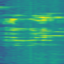

In [149]:
il[0].resize((64,64))

In [150]:
def make_rgb(item): return item.convert('RGB')

In [151]:
tfms = [ResizeFixed(26), make_rgb, to_byte_tensor, to_float_tensor, ToCuda()]
il = ImageList.from_files(train_v2, tfms = tfms)
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid=0.2))
ll = label_by_func(sd, emotion_labeler, proc_y=CategoryProcessor())

In [152]:
x, y = ll.train[0]

<class 'PIL.PngImagePlugin.PngImageFile'>


In [ ]:
bs=64
c_in = ll.train[0][0].shape[0]
c_out = len(uniqueify(ll.train.y))

In [ ]:
c_in, c_out

(3, 4)

In [ ]:
data = ll.to_databunch(bs,c_in=c_in,c_out=c_out)

In [ ]:
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)
loss_func = LabelSmoothingCrossEntropy()
lr = 1e-2
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95,0.85, 0.95))
cbscheds = [ParamScheduler('lr', sched_lr),
ParamScheduler('mom', sched_mom)]

In [ ]:
learn = cnn_learner(xresnet34, data, loss_func, opt_func)

In [ ]:
!pip install -qq torchmetrics

     |████████████████████████████████| 332 kB 5.0 MB/s 


In [ ]:
from torchmetrics import F1
f1 = F1(num_classes=4)

In [ ]:
learn.fit(100, cbs=cbscheds)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.245809,0.445051,1.297476,0.471602,00:19
1,1.244118,0.449382,1.426913,0.406509,00:19
2,1.216406,0.462859,1.336968,0.372048,00:19
3,1.189119,0.486283,1.169613,0.500319,00:19
4,1.149366,0.515161,1.159650,0.509892,00:20


/content/course-v3/nbs/dl2/exp/nb_09.py:136: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  state['grad_avg'].mul_(mom).add_(state['mom_damp'], p.grad.data)


---